In [1]:
import SimpleITK as sitk
import numpy as np
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed

In [2]:
def display_with_overlay(filename, slice_number, image, comp_seg, radio_seg, window_min, window_max):
    """
    Interactively display a CT slice with segmented contours overlaid onto it. The contours are the edges of the labeled regions.
    """

    img = image[:,:,slice_number]
    comp_msk = comp_seg[:,:,slice_number]
    radio_msk = radio_seg[:,:,slice_number]

    overlay_img = sitk.LabelMapContourOverlay(sitk.Cast(comp_msk, sitk.sitkLabelUInt8), 
                sitk.Cast(sitk.IntensityWindowing(img, windowMinimum=window_min, windowMaximum=window_max), sitk.sitkUInt8), 
                opacity = 1, contourThickness=[2,2])
    overlay_img2 = sitk.LabelMapContourOverlay(sitk.Cast(radio_msk, sitk.sitkLabelUInt8),
                     sitk.Cast(sitk.IntensityWindowing(img, windowMinimum=window_min, windowMaximum=window_max), sitk.sitkUInt8), 
                     opacity = 1, contourThickness=[2,2])

    plt.imshow(np.concatenate((sitk.GetArrayViewFromImage(overlay_img),sitk.GetArrayViewFromImage(overlay_img2)), axis=1))
    plt.axis('off')
    plt.show()

In [3]:
def display_with_overlay2(filename, slice_number, image, comp_seg, radio_seg, window_min, window_max):
    """
    Export a CT slice (in png) with both computerized (green) and radiologist (red) segmented contours overlaid onto it. The contours 
    are the edges of the labeled regions.
    """

    img = image[:,:,slice_number]
    comp_msk = comp_seg[:,:,slice_number]
    radio_msk = radio_seg[:,:,slice_number]

    # Impose computerized contour on the CT slice
    overlay_img = sitk.LabelMapContourOverlay(sitk.Cast(comp_msk, sitk.sitkLabelUInt8), 
                sitk.Cast(sitk.IntensityWindowing(img, windowMinimum=window_min, windowMaximum=window_max), sitk.sitkUInt8), 
                opacity = 1, contourThickness=[2,2])
    outputFileName = "/Users/catherine/Desktop/Research/Test/results/" + file + "_slice" + str(slice_number) + "_result.png"
    outputFileName2 = "/Users/catherine/Desktop/Research/Test/results/" + file + "_radio.png"
    sitk.WriteImage(radio_msk, outputFileName2)
    sitk.WriteImage(overlay_img, outputFileName)

    # Impose radiologist contour on the CT slice
    seg = cv2.imread(outputFileName2, cv2.IMREAD_GRAYSCALE)
    main = cv2.imread(outputFileName)
    contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for i,c in enumerate(contours):
        mask = np.zeros(seg.shape, np.uint8)
        cv2.drawContours(mask,[c],-1, 255, -1)
        mean, _, _, _ = cv2.mean(seg, mask=mask)
        # Outline contour in that colour on main image, line thickness=1
        cv2.drawContours(main, [c], -1, (0,0,255), 1)

    cv2.imwrite(outputFileName, main)
    os.remove(outputFileName2)

In [4]:
file = input("Enter the file name: ")
comp_path = "/Users/catherine/Desktop/Research/eyeball-segmentation-evaluation/eyeball-computer-results/" + file + "_img.nii"
radio_path = "/Users/catherine/Desktop/Research/eyeball-segmentation-evaluation/msk-eyeball-radiologist-results/" + file + "_msk.nii"
CT_path = "/Users/catherine/Desktop/Research/eyeball-segmentation-evaluation/img-eyeball/" + file + "_img.nii"
comp_image = sitk.ReadImage(comp_path)
radio_image = sitk.ReadImage(radio_path)
CT_image = sitk.ReadImage(CT_path)

slice_number = int(input("Enter the slice number: "))
if (slice_number >= CT_image.GetSize()[2]):
    print("Slice number out of bound!")

display_with_overlay2(file, slice_number, image = CT_image, comp_seg = comp_image, radio_seg = radio_image, 
        window_min = -1024, window_max=976)
interact(display_with_overlay, filename = file, slice_number = (0, CT_image.GetSize()[2]-1), image = fixed(CT_image),
         comp_seg = fixed(comp_image), radio_seg = fixed(radio_image), window_min = fixed(-1024), window_max=fixed(976));


RuntimeError: Exception thrown in SimpleITK ReadImage: /Users/runner/runners/2.160.0/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "/Users/catherine/Desktop/Research/Test/eyeball-computer-results/HB039124OAV_00351_2015-07-13_4_img.nii" does not exist.

In [14]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class PerformanceMetrics(Enum):
    dice, iou, mcc, acc, hausdorff_distance = range(5)

computer = comp_image
radiologist = radio_image

# Empty numpy arrays to hold the results 
results = np.zeros((1, len(PerformanceMetrics.__members__.items())))

# Compute the performance metrics
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

overlap_measures_filter.Execute(computer, radiologist)
results[0, PerformanceMetrics.dice.value] = overlap_measures_filter.GetDiceCoefficient()
results[0, PerformanceMetrics.iou.value] = overlap_measures_filter.GetJaccardCoefficient()
fp = overlap_measures_filter.GetFalsePositiveError()
tn = 1 - fp
fn = overlap_measures_filter.GetFalseNegativeError()
tp = 1 - fn
results[0, PerformanceMetrics.mcc.value] = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
results[0, PerformanceMetrics.acc.value] = (tp + tn) / (tp + fp + tn + fn)

hausdorff_distance_filter.Execute(computer, radiologist)
results[0,PerformanceMetrics.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()

print(results)


[[0.78988162 0.65273087 0.59654882 0.79556487 3.75      ]]


,dice,iou,mcc,acc,hausdorff_distance
0,0.790,0.653,0.597,0.796,3.750


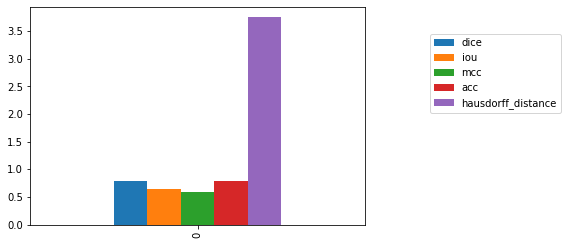

In [15]:
import pandas as pd
from IPython.display import display, HTML 

# Graft result matrix into pandas data frames
results_df = pd.DataFrame(data=results, index = list(range(1)), 
                                  columns=[name for name, _ in PerformanceMetrics.__members__.items()]) 
display(HTML(results_df.to_html(float_format=lambda x: '%.3f' % x)))
results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
